In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
plt.rcParams['font.sans-serif'] = ['Hiragino Sans', 'Yu Gothic', 'IPAexGothic', 'Noto Sans CJK JP']
plt.rcParams['axes.unicode_minus'] = False
def safe_corr(df, a, b):
    sub = df[[a,b]].dropna()
    if len(sub) < 2: return np.nan
    if sub[a].nunique() < 2 or sub[b].nunique() < 2: return np.nan
    return round(float(sub[a].corr(sub[b])), 3)

In [ ]:
df23_24 = pd.read_csv('/Users/nakamurawataru/Documents/学校/研究室/SDSC/03.バスケ/6月送付分/【2025年度】プレイバイプレイ_23-24シーズン.csv')
df24_25 = pd.read_csv('/Users/nakamurawataru/Documents/学校/研究室/SDSC/03.バスケ/6月送付分/【2025年度】プレイバイプレイ_24-25シーズン.csv')
df_box = pd.read_csv('/Users/nakamurawataru/Documents/学校/研究室/SDSC/03.バスケ/6月送付分/【2025年度】ボックススコア.csv')
df_game = pd.read_csv('/Users/nakamurawataru/Documents/学校/研究室/SDSC/03.バスケ/6月送付分/【2025年度】試合データ.csv')

use = pd.concat([df23_24, df24_25], ignore_index=True)

df_game_alphas = df_game[(df_game['ホームチームID'] == 745) | (df_game['アウェイチームID'] == 745)]

def close_game(df, team_id):
    df = df.copy()
    m_home = df['ホームチームID'] == team_id
    m_away = df['アウェイチームID'] == team_id

    df['得点差'] = np.where(
        m_home, df['ホーム得点'] - df['アウェイ得点'],
        np.where(m_away, df['アウェイ得点'] - df['ホーム得点'], np.nan)
    )
    return df

,試合ID,得点差
0,501291,NaN
1,501292,NaN
2,501293,NaN
3,501294,NaN
4,501295,NaN
...,...,...
2347,503922,NaN
2348,503923,NaN
2349,503924,NaN
2350,503925,NaN


In [71]:
def get_team_scores(df_game, team_id):
    """指定チーム視点での得点・失点・得点差を返す"""
    df = df_game.copy()
    m_home = df['ホームチームID'] == team_id
    m_away = df['アウェイチームID'] == team_id

    # 自チームの得点と失点を両パターンで定義
    df['自チームID'] = np.where(m_home | m_away, team_id, np.nan)
    df['自チーム得点'] = np.where(m_home, df['ホーム得点'],
                            np.where(m_away, df['アウェイ得点'], np.nan))
    df['相手チーム得点'] = np.where(m_home, df['アウェイ得点'],
                            np.where(m_away, df['ホーム得点'], np.nan))
    df['得点差'] = df['自チーム得点'] - df['相手チーム得点']

    # 自チームが出ていない試合は除外
    df = df[m_home | m_away].copy()

    # 必要な列だけ残す
    return df[['試合ID','自チームID','自チーム得点','相手チーム得点','得点差']]

df697 = get_team_scores(df_game, 697)
df745 = get_team_scores(df_game, 745)
df745

,試合ID,自チームID,自チーム得点,相手チーム得点,得点差
726,502017,745.0,75.0,65.0,10.0
727,502018,745.0,80.0,46.0,34.0
738,502029,745.0,100.0,95.0,5.0
739,502030,745.0,77.0,81.0,-4.0
754,502045,745.0,80.0,87.0,-7.0
...,...,...,...,...,...
1840,503374,745.0,75.0,74.0,1.0
1852,503386,745.0,50.0,60.0,-10.0
1853,503387,745.0,75.0,74.0,1.0
1876,503410,745.0,62.0,91.0,-29.0


In [95]:
#越谷アルファーズを計算
df_game_alphas_game = close_game(df_game_alphas,745)
df_game_alphas_gameid_scores = df_game_alphas_game[['試合ID','得点差']].copy()

df_box_gameid = df_box.drop(columns=[ 'ホームアウェイ','チーム名','チーム名英','選手ID','背番号','選手名','スターティングフラグ','プレイタイム'])
df_box_gameid_sum = df_box_gameid[df_box_gameid['ピリオド区分'] == 18].groupby(['試合ID','チームID']).sum().reset_index()
df_box_gameid_sum_alphas = df_box_gameid_sum[df_box_gameid_sum['チームID'] == 745]
df_box_gameid_sum_alphas_scores_marged  = df_box_gameid_sum_alphas.merge(df_game_alphas_gameid_scores, on='試合ID', how='left')
df_box_gameid_sum_alphas_scores = df_box_gameid_sum_alphas_scores_marged.groupby('得点差').mean().reset_index()

In [101]:
top_team = [697 ,701 , 703, 704, 706, 720, 728, 729]

df_game_scores = close_game(df_game,703)

df_box_gameid_sum2 = df_box_gameid_sum[df_box_gameid_sum['チームID'] == 703]
df_box_gameid_sum2 = df_box_gameid_sum2.merge(df697, on='試合ID', how='left')
df_box_gameid_sum2 = df_box_gameid_sum2.groupby('得点差').mean().reset_index()
df_box_gameid_sum2

,得点差,試合ID,チームID,ピリオド区分,得点,3P成功,3P試投,2P成功,2P試投,ダンク,...,アシスト,スティール,ブロックショット,被ブロックショット,ファストブレイクポイント,2Pインサイドポイント,セカンドチャンスポイント,自チームID,自チーム得点,相手チーム得点
0,-2.0,502312.0,703.0,234.0,81.5,10.0,31.5,20.0,40.0,1.5,...,19.0,2.0,1.5,4.0,6.5,35.0,12.5,697.0,79.5,81.5
1,16.0,502312.0,703.0,234.0,81.0,11.0,33.5,17.5,35.0,1.0,...,20.0,8.0,0.5,2.5,14.0,33.0,15.5,697.0,97.0,81.0


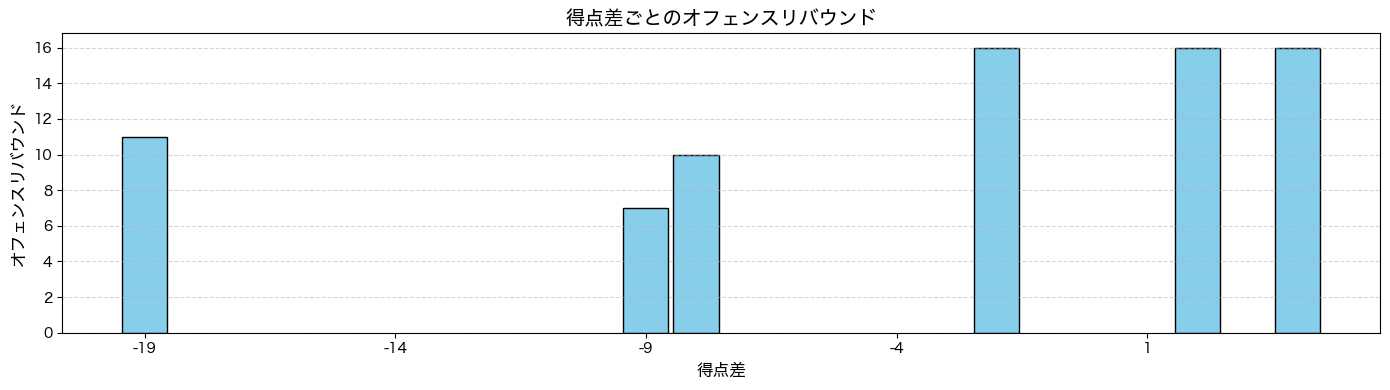

In [90]:
x = df_box_gameid_sum2['得点差']
y = df_box_gameid_sum2['オフェンスリバウンド']

plt.figure(figsize=(14, 4))
plt.bar(x, y, width=0.9, color='skyblue', edgecolor='black', align='center')

plt.xlabel("得点差", fontsize=12)
plt.ylabel("オフェンスリバウンド", fontsize=12)
plt.title("得点差ごとのオフェンスリバウンド", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.xticks(range(int(x.min()), int(x.max()) + 1, 5))

plt.tight_layout()
plt.show()

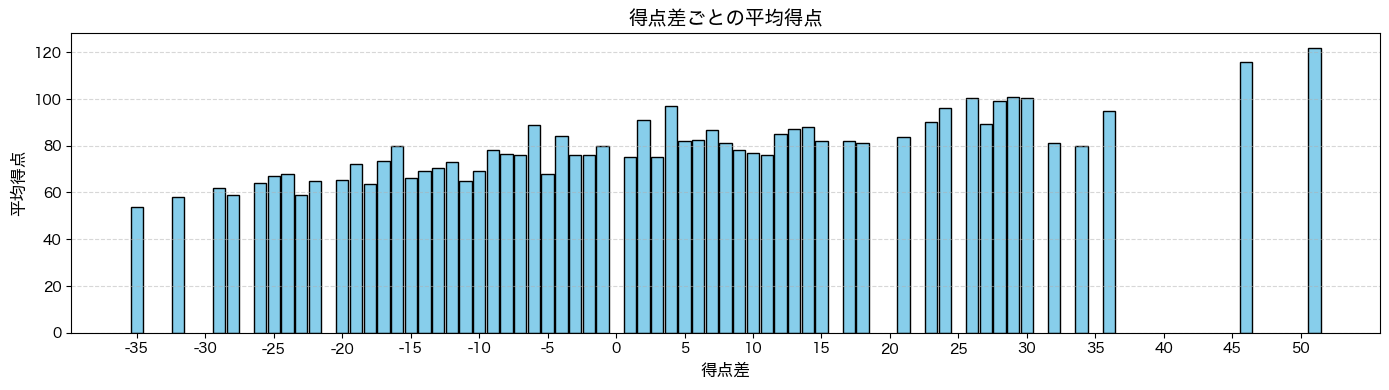

In [28]:
x = df_box_gameid_sum_alphas_scores['得点差']
y = df_box_gameid_sum_alphas_scores['得点']

plt.figure(figsize=(14, 4))
plt.bar(x, y, width=0.9, color='skyblue', edgecolor='black', align='center')

plt.xlabel("得点差", fontsize=12)
plt.ylabel("平均得点", fontsize=12)
plt.title("得点差ごとの平均得点", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# x軸の目盛りを少し細かく（5刻みなど）
plt.xticks(range(int(x.min()), int(x.max()) + 1, 5))

plt.tight_layout()
plt.show()

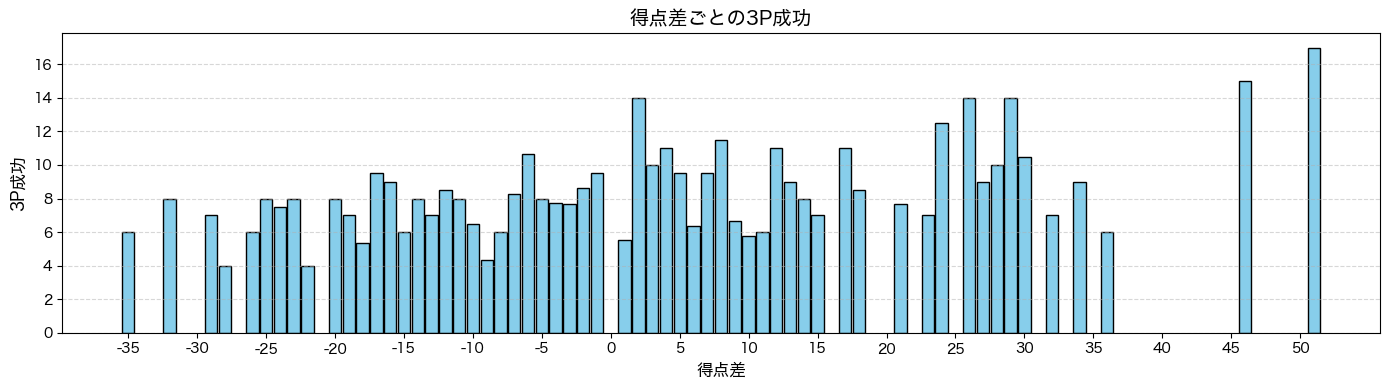

In [61]:
x = df_box_gameid_sum_alphas_scores['得点差']
y = df_box_gameid_sum_alphas_scores['3P成功']

plt.figure(figsize=(14, 4))
plt.bar(x, y, width=0.9, color='skyblue', edgecolor='black', align='center')

plt.xlabel("得点差", fontsize=12)
plt.ylabel("3P成功", fontsize=12)
plt.title("得点差ごとの3P成功", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# x軸の目盛りを少し細かく（5刻みなど）
plt.xticks(range(int(x.min()), int(x.max()) + 1, 5))

plt.tight_layout()
plt.show()

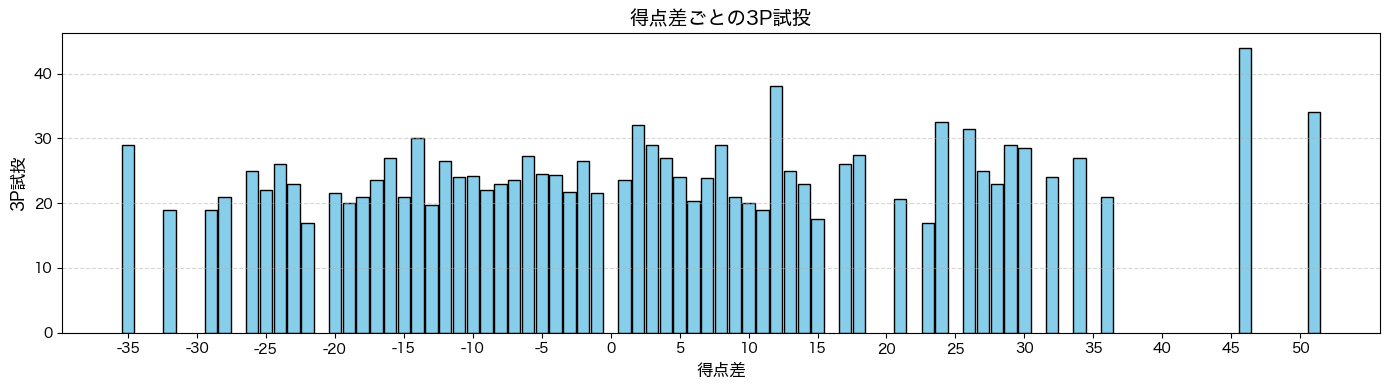

In [60]:
x = df_box_gameid_sum_alphas_scores['得点差']
y = df_box_gameid_sum_alphas_scores['3P試投']

plt.figure(figsize=(14, 4))
plt.bar(x, y, width=0.9, color='skyblue', edgecolor='black', align='center')

plt.xlabel("得点差", fontsize=12)
plt.ylabel("3P試投", fontsize=12)
plt.title("得点差ごとの3P試投", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# x軸の目盛りを少し細かく（5刻みなど）
plt.xticks(range(int(x.min()), int(x.max()) + 1, 5))

plt.tight_layout()
plt.show()

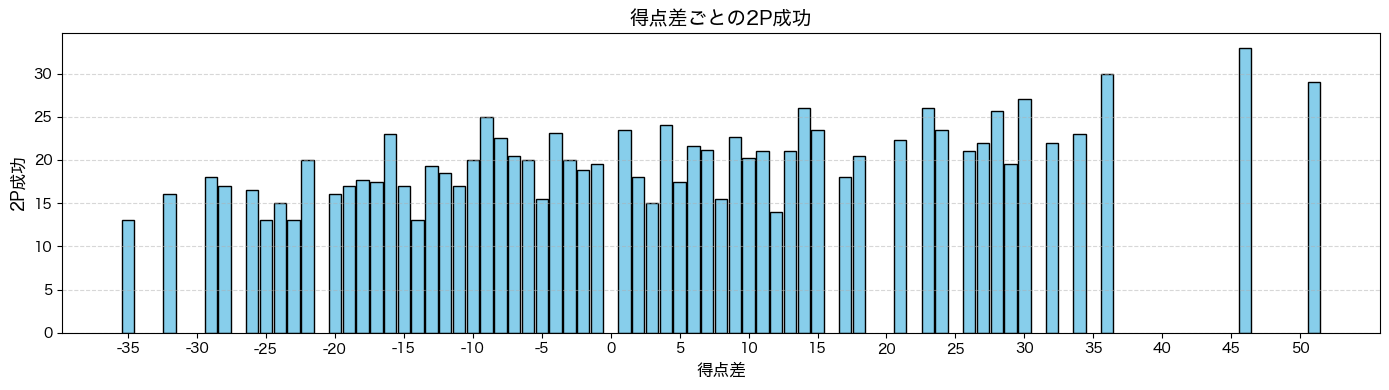

In [59]:
x = df_box_gameid_sum_alphas_scores['得点差']
y = df_box_gameid_sum_alphas_scores['2P成功']

plt.figure(figsize=(14, 4))
plt.bar(x, y, width=0.9, color='skyblue', edgecolor='black', align='center')

plt.xlabel("得点差", fontsize=12)
plt.ylabel("2P成功", fontsize=12)
plt.title("得点差ごとの2P成功", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# x軸の目盛りを少し細かく（5刻みなど）
plt.xticks(range(int(x.min()), int(x.max()) + 1, 5))

plt.tight_layout()
plt.show()

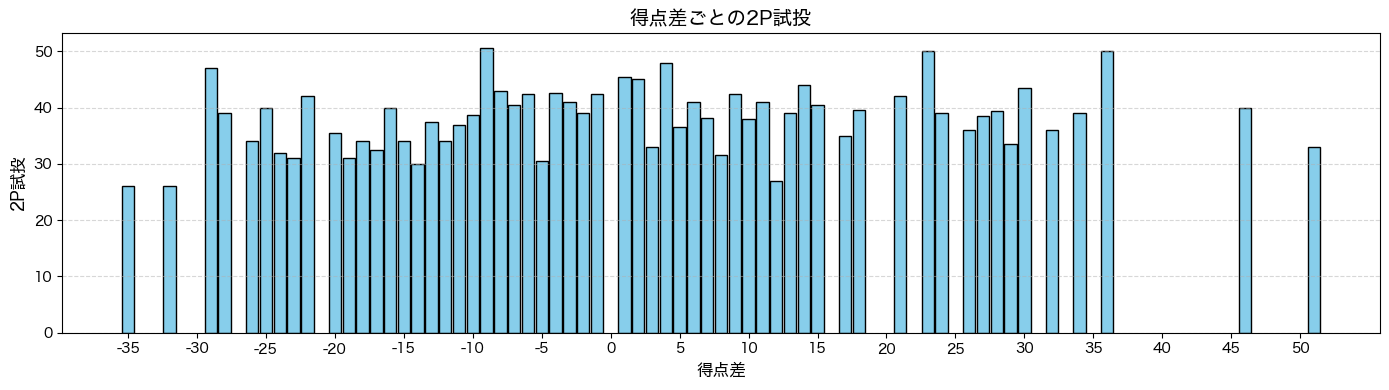

In [58]:
x = df_box_gameid_sum_alphas_scores['得点差']
y = df_box_gameid_sum_alphas_scores['2P試投']

plt.figure(figsize=(14, 4))
plt.bar(x, y, width=0.9, color='skyblue', edgecolor='black', align='center')

plt.xlabel("得点差", fontsize=12)
plt.ylabel("2P試投", fontsize=12)
plt.title("得点差ごとの2P試投", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# x軸の目盛りを少し細かく（5刻みなど）
plt.xticks(range(int(x.min()), int(x.max()) + 1, 5))

plt.tight_layout()
plt.show()

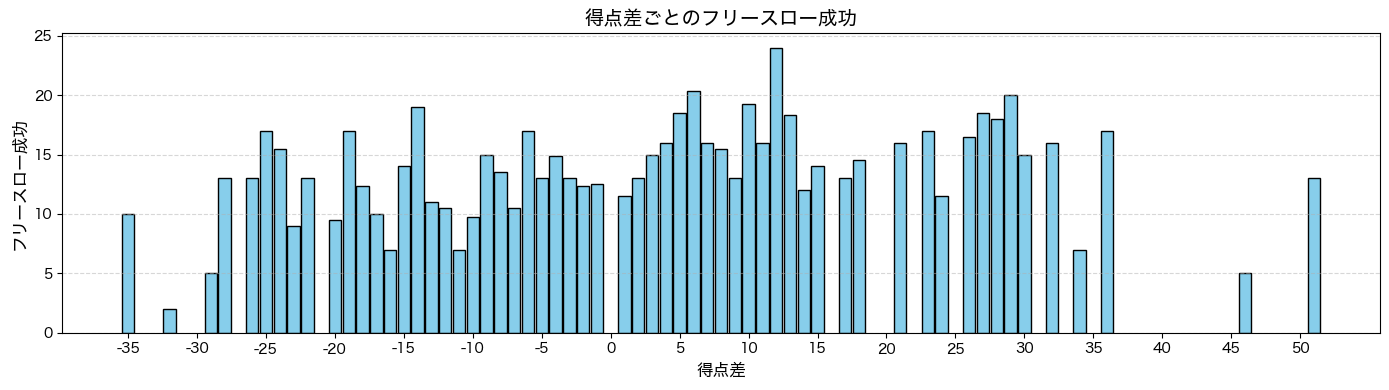

In [57]:
x = df_box_gameid_sum_alphas_scores['得点差']
y = df_box_gameid_sum_alphas_scores['フリースロー成功']

plt.figure(figsize=(14, 4))
plt.bar(x, y, width=0.9, color='skyblue', edgecolor='black', align='center')

plt.xlabel("得点差", fontsize=12)
plt.ylabel("フリースロー成功", fontsize=12)
plt.title("得点差ごとのフリースロー成功", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# x軸の目盛りを少し細かく（5刻みなど）
plt.xticks(range(int(x.min()), int(x.max()) + 1, 5))

plt.tight_layout()
plt.show()

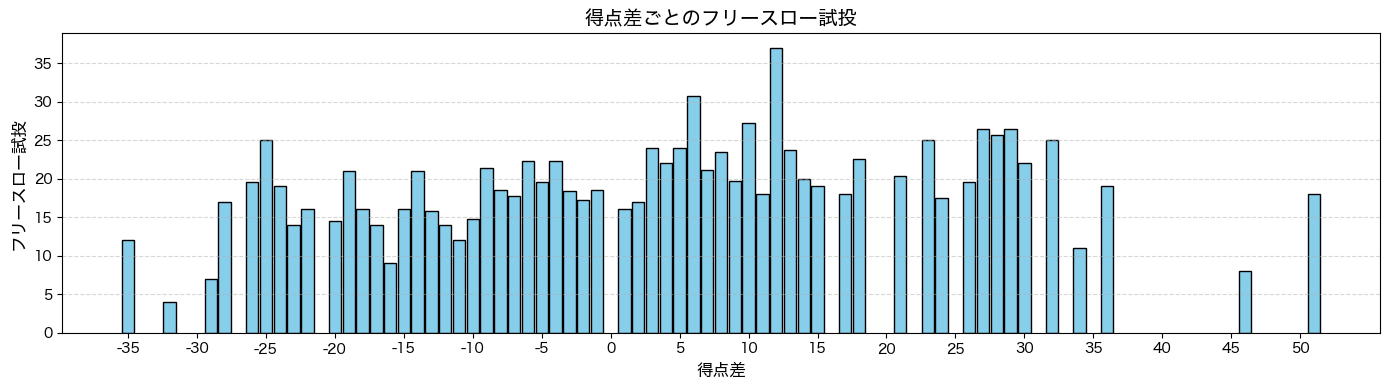

In [56]:
x = df_box_gameid_sum_alphas_scores['得点差']
y = df_box_gameid_sum_alphas_scores['フリースロー試投']

plt.figure(figsize=(14, 4))
plt.bar(x, y, width=0.9, color='skyblue', edgecolor='black', align='center')

plt.xlabel("得点差", fontsize=12)
plt.ylabel("フリースロー試投", fontsize=12)
plt.title("得点差ごとのフリースロー試投", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# x軸の目盛りを少し細かく（5刻みなど）
plt.xticks(range(int(x.min()), int(x.max()) + 1, 5))

plt.tight_layout()
plt.show()

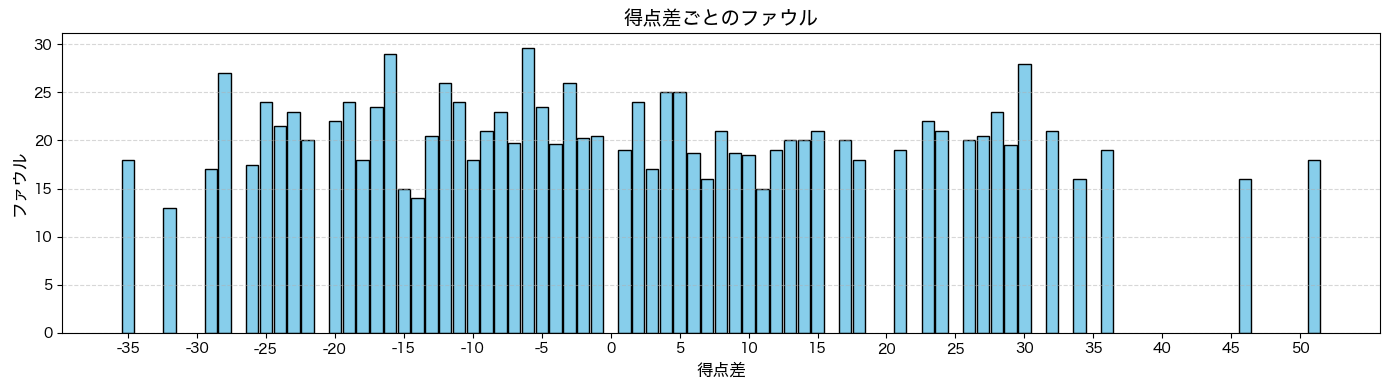

In [55]:
x = df_box_gameid_sum_alphas_scores['得点差']
y = df_box_gameid_sum_alphas_scores['ファウル']

plt.figure(figsize=(14, 4))
plt.bar(x, y, width=0.9, color='skyblue', edgecolor='black', align='center')

plt.xlabel("得点差", fontsize=12)
plt.ylabel("ファウル", fontsize=12)
plt.title("得点差ごとのファウル", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# x軸の目盛りを少し細かく（5刻みなど）
plt.xticks(range(int(x.min()), int(x.max()) + 1, 5))

plt.tight_layout()
plt.show()

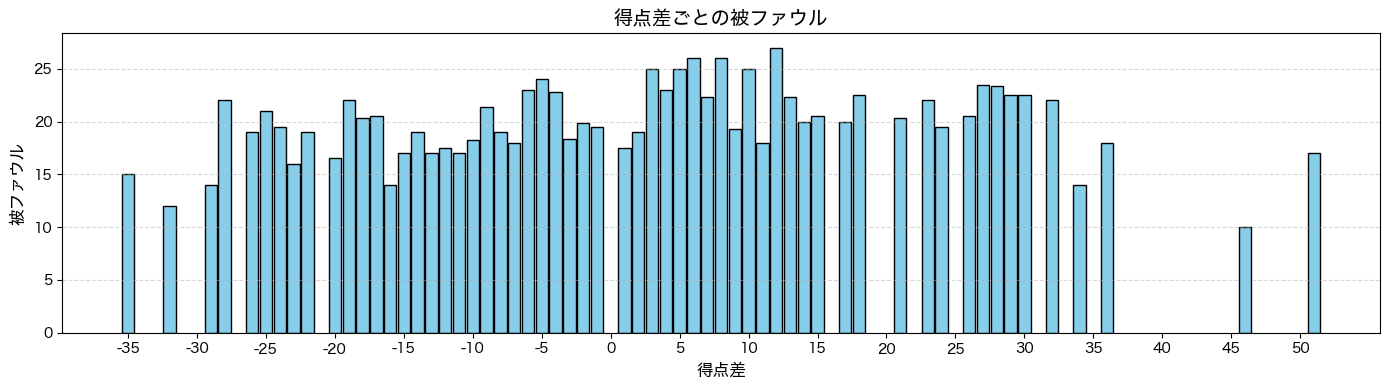

In [54]:
x = df_box_gameid_sum_alphas_scores['得点差']
y = df_box_gameid_sum_alphas_scores['被ファウル']

plt.figure(figsize=(14, 4))
plt.bar(x, y, width=0.9, color='skyblue', edgecolor='black', align='center')

plt.xlabel("得点差", fontsize=12)
plt.ylabel("被ファウル", fontsize=12)
plt.title("得点差ごとの被ファウル", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# x軸の目盛りを少し細かく（5刻みなど）
plt.xticks(range(int(x.min()), int(x.max()) + 1, 5))

plt.tight_layout()
plt.show()

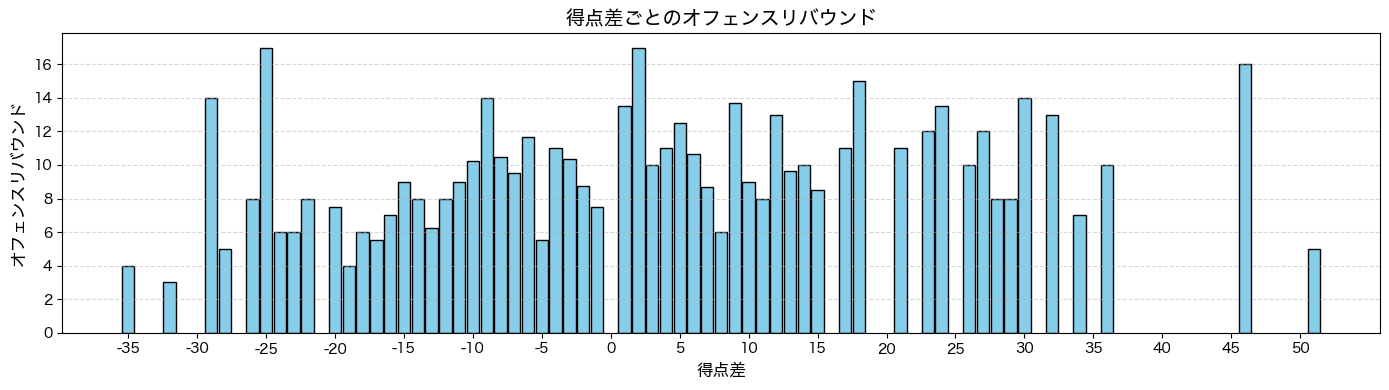

In [53]:
x = df_box_gameid_sum_alphas_scores['得点差']
y = df_box_gameid_sum_alphas_scores['オフェンスリバウンド']

plt.figure(figsize=(14, 4))
plt.bar(x, y, width=0.9, color='skyblue', edgecolor='black', align='center')

plt.xlabel("得点差", fontsize=12)
plt.ylabel("オフェンスリバウンド", fontsize=12)
plt.title("得点差ごとのオフェンスリバウンド", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# x軸の目盛りを少し細かく（5刻みなど）
plt.xticks(range(int(x.min()), int(x.max()) + 1, 5))

plt.tight_layout()
plt.show()

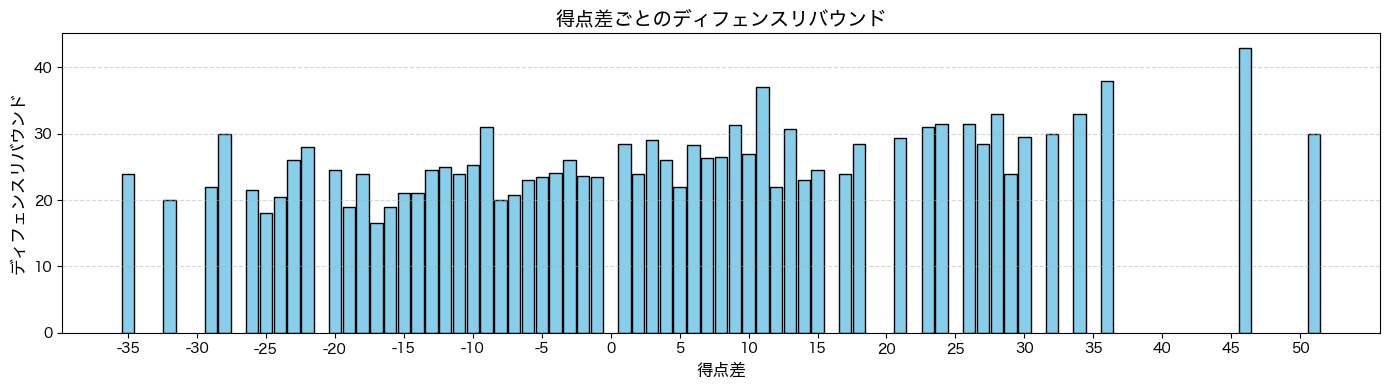

In [52]:
x = df_box_gameid_sum_alphas_scores['得点差']
y = df_box_gameid_sum_alphas_scores['ディフェンスリバウンド']

plt.figure(figsize=(14, 4))
plt.bar(x, y, width=0.9, color='skyblue', edgecolor='black', align='center')

plt.xlabel("得点差", fontsize=12)
plt.ylabel("ディフェンスリバウンド", fontsize=12)
plt.title("得点差ごとのディフェンスリバウンド", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# x軸の目盛りを少し細かく（5刻みなど）
plt.xticks(range(int(x.min()), int(x.max()) + 1, 5))

plt.tight_layout()
plt.show()

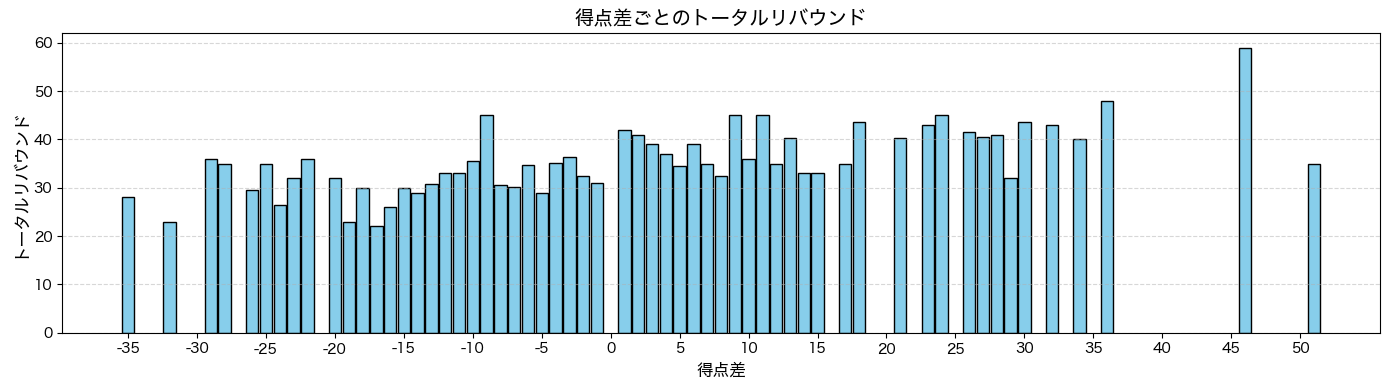

In [51]:
x = df_box_gameid_sum_alphas_scores['得点差']
y = df_box_gameid_sum_alphas_scores['トータルリバウンド']

plt.figure(figsize=(14, 4))
plt.bar(x, y, width=0.9, color='skyblue', edgecolor='black', align='center')

plt.xlabel("得点差", fontsize=12)
plt.ylabel("トータルリバウンド", fontsize=12)
plt.title("得点差ごとのトータルリバウンド", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# x軸の目盛りを少し細かく（5刻みなど）
plt.xticks(range(int(x.min()), int(x.max()) + 1, 5))

plt.tight_layout()
plt.show()

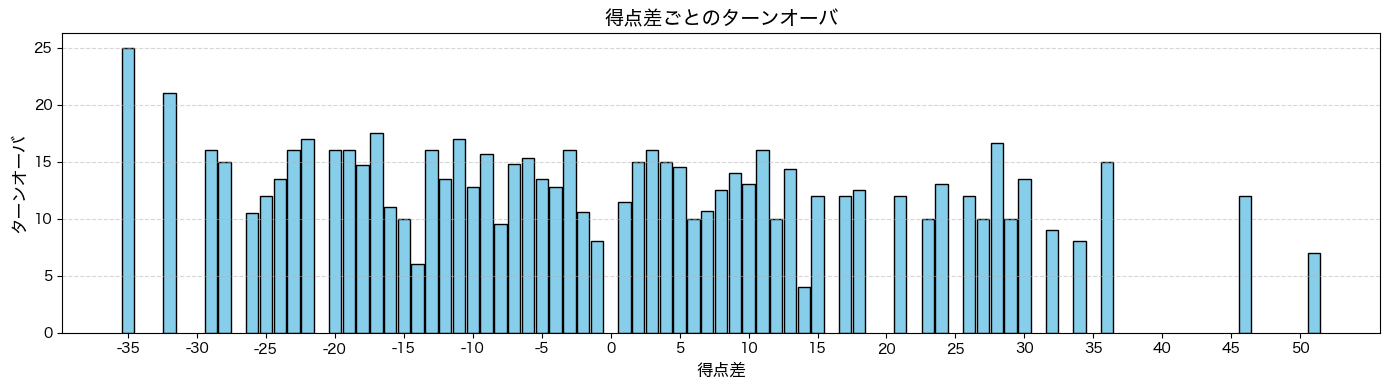

In [50]:
x = df_box_gameid_sum_alphas_scores['得点差']
y = df_box_gameid_sum_alphas_scores['ターンオーバ']

plt.figure(figsize=(14, 4))
plt.bar(x, y, width=0.9, color='skyblue', edgecolor='black', align='center')

plt.xlabel("得点差", fontsize=12)
plt.ylabel("ターンオーバ", fontsize=12)
plt.title("得点差ごとのターンオーバ", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# x軸の目盛りを少し細かく（5刻みなど）
plt.xticks(range(int(x.min()), int(x.max()) + 1, 5))

plt.tight_layout()
plt.show()

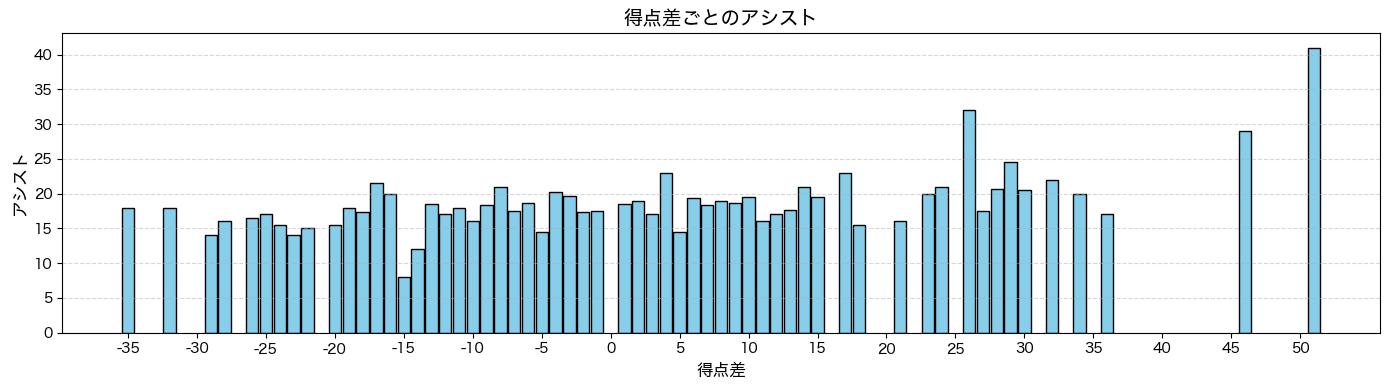

In [49]:
x = df_box_gameid_sum_alphas_scores['得点差']
y = df_box_gameid_sum_alphas_scores['アシスト']

plt.figure(figsize=(14, 4))
plt.bar(x, y, width=0.9, color='skyblue', edgecolor='black', align='center')

plt.xlabel("得点差", fontsize=12)
plt.ylabel("アシスト", fontsize=12)
plt.title("得点差ごとのアシスト", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# x軸の目盛りを少し細かく（5刻みなど）
plt.xticks(range(int(x.min()), int(x.max()) + 1, 5))

plt.tight_layout()
plt.show()

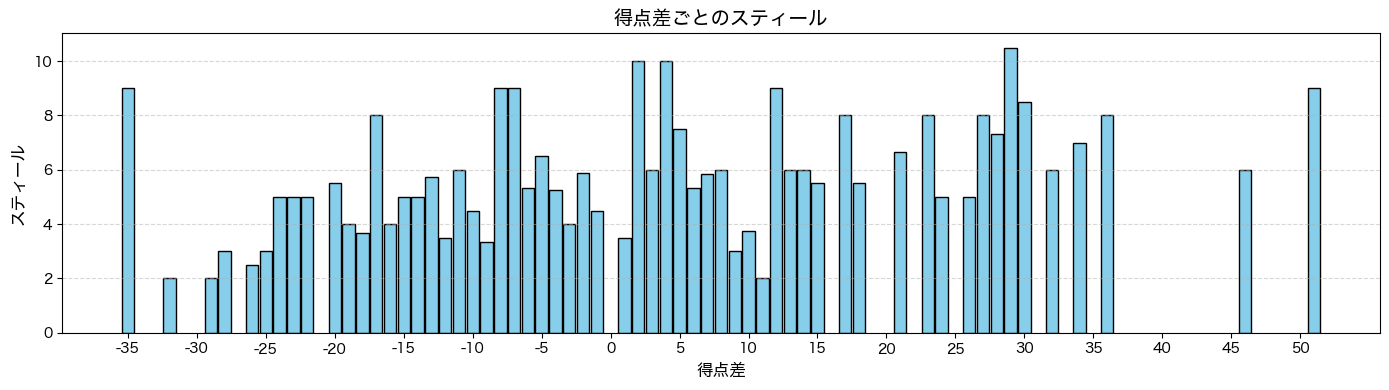

In [48]:
x = df_box_gameid_sum_alphas_scores['得点差']
y = df_box_gameid_sum_alphas_scores['スティール']

plt.figure(figsize=(14, 4))
plt.bar(x, y, width=0.9, color='skyblue', edgecolor='black', align='center')

plt.xlabel("得点差", fontsize=12)
plt.ylabel("スティール", fontsize=12)
plt.title("得点差ごとのスティール", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# x軸の目盛りを少し細かく（5刻みなど）
plt.xticks(range(int(x.min()), int(x.max()) + 1, 5))

plt.tight_layout()
plt.show()

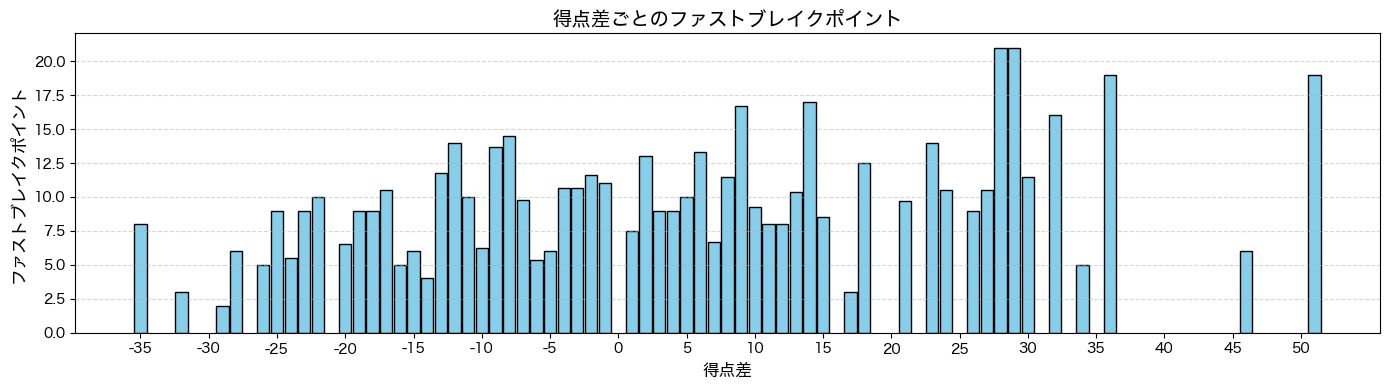

In [46]:
x = df_box_gameid_sum_alphas_scores['得点差']
y = df_box_gameid_sum_alphas_scores['ファストブレイクポイント']

plt.figure(figsize=(14, 4))
plt.bar(x, y, width=0.9, color='skyblue', edgecolor='black', align='center')

plt.xlabel("得点差", fontsize=12)
plt.ylabel("ファストブレイクポイント", fontsize=12)
plt.title("得点差ごとのファストブレイクポイント", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# x軸の目盛りを少し細かく（5刻みなど）
plt.xticks(range(int(x.min()), int(x.max()) + 1, 5))

plt.tight_layout()
plt.show()

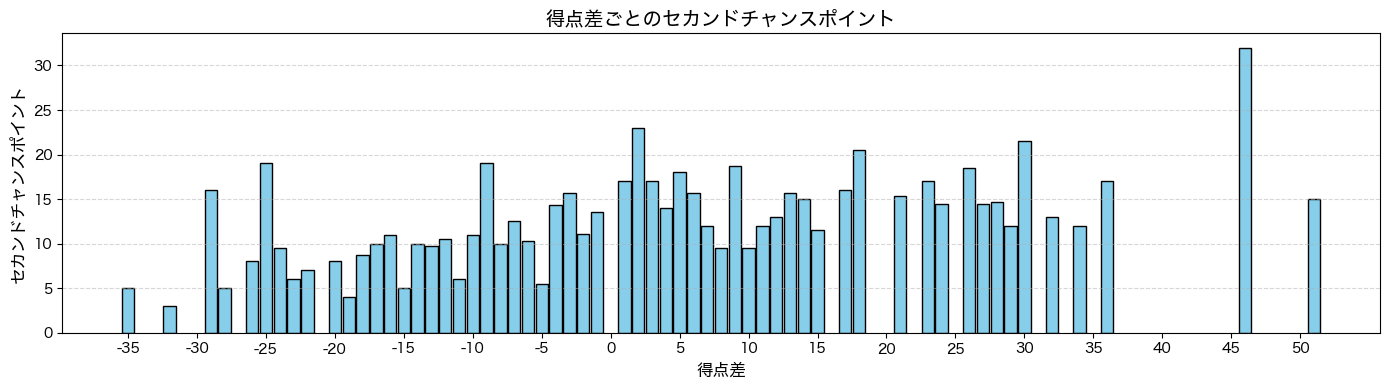

In [47]:
x = df_box_gameid_sum_alphas_scores['得点差']
y = df_box_gameid_sum_alphas_scores['セカンドチャンスポイント']

plt.figure(figsize=(14, 4))
plt.bar(x, y, width=0.9, color='skyblue', edgecolor='black', align='center')

plt.xlabel("得点差", fontsize=12)
plt.ylabel("セカンドチャンスポイント", fontsize=12)
plt.title("得点差ごとのセカンドチャンスポイント", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# x軸の目盛りを少し細かく（5刻みなど）
plt.xticks(range(int(x.min()), int(x.max()) + 1, 5))

plt.tight_layout()
plt.show()

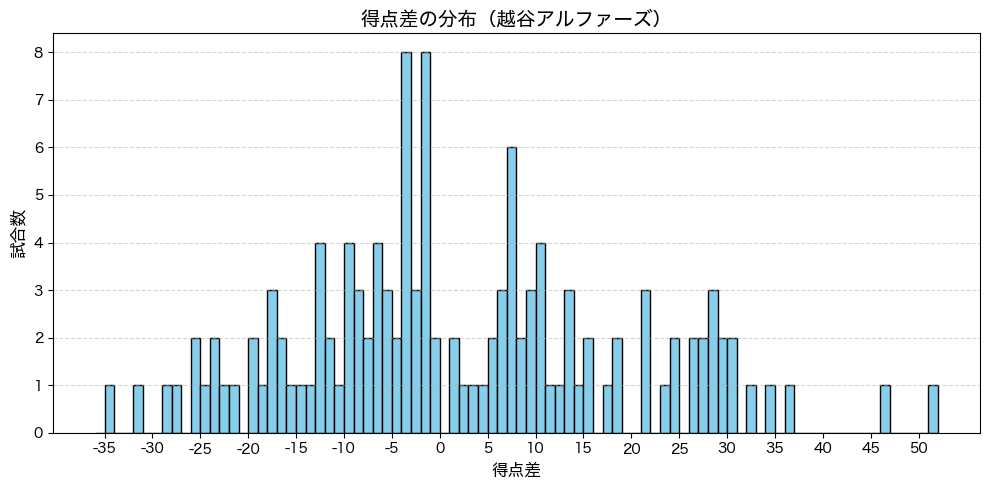

In [84]:
x = df_box_gameid_sum_alphas_scores_marged['得点差']

plt.figure(figsize=(10,5))
plt.hist(x, bins=np.arange(x.min()-1, x.max()+2, 1), color='skyblue', edgecolor='black')

plt.xlabel("得点差", fontsize=12)
plt.ylabel("試合数", fontsize=12)
plt.xticks(range(int(x.min()), int(x.max()) + 1, 5))
plt.title("得点差の分布（越谷アルファーズ）", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
df_box_gameid_sum_alphas_scores_marged

,得点差,試合ID,チームID,ピリオド区分,得点,3P成功,3P試投,2P成功,2P試投,ダンク,...,ディフェンスリバウンド,トータルリバウンド,ターンオーバ,アシスト,スティール,ブロックショット,被ブロックショット,ファストブレイクポイント,2Pインサイドポイント,セカンドチャンスポイント
0,-35.0,503028.000000,745.0,216.00,54.000000,6.000000,29.000000,13.000000,26.000000,1.000000,...,24.000000,28.000000,25.000000,18.000000,9.000000,2.000000,1.000000,8.000000,22.000000,5.000000
1,-32.0,503336.000000,745.0,180.00,58.000000,8.000000,19.000000,16.000000,26.000000,1.000000,...,20.000000,23.000000,21.000000,18.000000,2.000000,1.000000,0.000000,3.000000,30.000000,3.000000
2,-29.0,503410.000000,745.0,216.00,62.000000,7.000000,19.000000,18.000000,47.000000,0.000000,...,22.000000,36.000000,16.000000,14.000000,2.000000,0.000000,1.000000,2.000000,26.000000,16.000000
3,-28.0,502741.000000,745.0,198.00,59.000000,4.000000,21.000000,17.000000,39.000000,1.000000,...,30.000000,35.000000,15.000000,16.000000,3.000000,1.000000,4.000000,6.000000,28.000000,5.000000
4,-26.0,502785.500000,745.0,198.00,64.000000,6.000000,25.000000,16.500000,34.000000,1.000000,...,21.500000,29.500000,10.500000,16.500000,2.500000,1.500000,1.500000,5.000000,31.000000,8.000000
5,-25.0,503222.000000,745.0,216.00,67.000000,8.000000,22.000000,13.000000,40.000000,2.000000,...,18.000000,35.000000,12.000000,17.000000,3.000000,0.000000,4.000000,9.000000,26.000000,19.000000
6,-24.0,503059.000000,745.0,216.00,68.000000,7.500000,26.000000,15.000000,32.000000,0.500000,...,20.500000,26.500000,13.500000,15.500000,5.000000,1.000000,2.000000,5.500000,27.000000,9.500000
7,-23.0,502831.000000,745.0,216.00,59.000000,8.000000,23.000000,13.000000,31.000000,1.000000,...,26.000000,32.000000,16.000000,14.000000,5.000000,3.000000,1.000000,9.000000,24.000000,6.000000
8,-22.0,502740.000000,745.0,198.00,65.000000,4.000000,17.000000,20.000000,42.000000,4.000000,...,28.000000,36.000000,17.000000,15.000000,5.000000,3.000000,4.000000,10.000000,40.000000,7.000000
9,-20.0,502701.500000,745.0,216.00,65.500000,8.000000,21.500000,16.000000,35.500000,0.000000,...,24.500000,32.000000,16.000000,15.500000,5.500000,2.000000,2.000000,6.500000,24.000000,8.000000


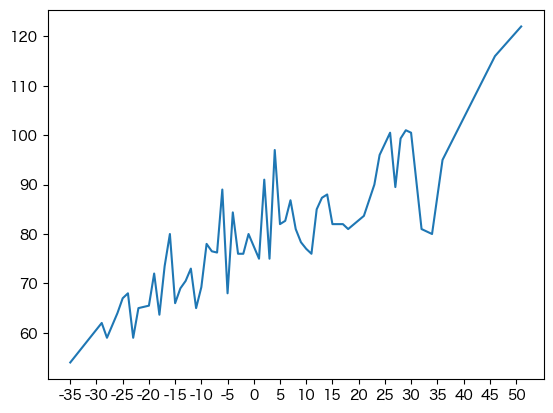

In [5]:
x = df_box_gameid_sum_alphas_scores['得点差']
y = df_box_gameid_sum_alphas_scores['得点']
plt.plot(x, y)
plt.xticks(np.arange(x.min(), x.max(), 5))
plt.show()

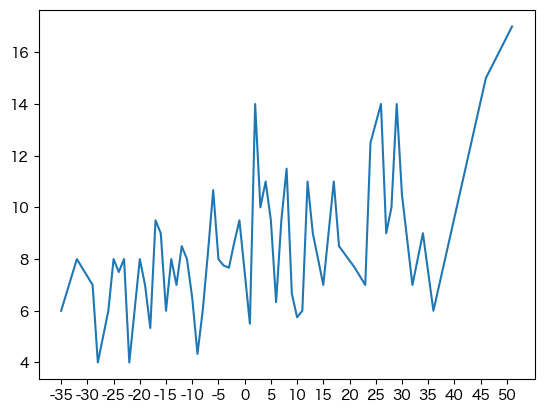

In [6]:
x = df_box_gameid_sum_alphas_scores['得点差']
y = df_box_gameid_sum_alphas_scores['3P成功']
plt.plot(x, y)
plt.xticks(np.arange(x.min(), x.max(), 5))
plt.show()

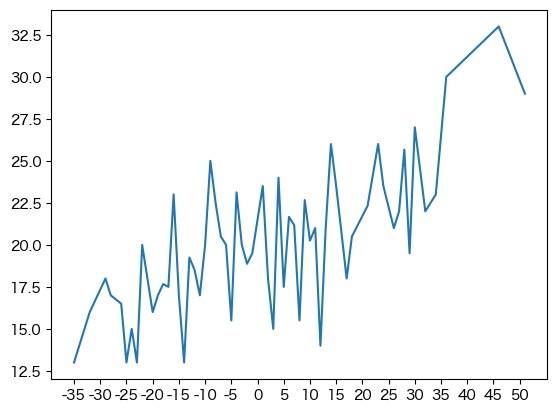

In [7]:
x = df_box_gameid_sum_alphas_scores['得点差']
y = df_box_gameid_sum_alphas_scores['2P成功']
plt.plot(x, y)
plt.xticks(np.arange(x.min(), x.max(), 5))
plt.show()

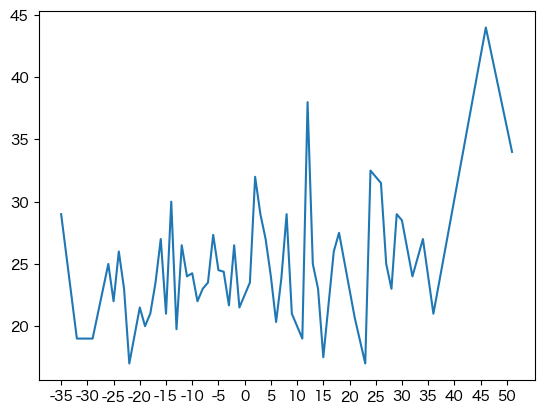

In [8]:
x = df_box_gameid_sum_alphas_scores['得点差']
y = df_box_gameid_sum_alphas_scores['3P試投']
plt.plot(x, y)
plt.xticks(np.arange(x.min(), x.max(), 5))
plt.show()

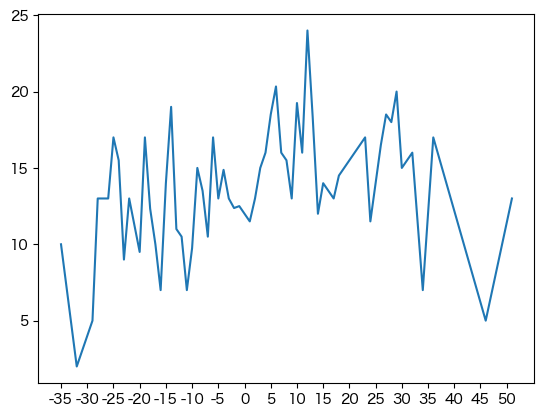

In [9]:
x = df_box_gameid_sum_alphas_scores['得点差']
y = df_box_gameid_sum_alphas_scores['フリースロー成功']
plt.plot(x, y)
plt.xticks(np.arange(x.min(), x.max(), 5))
plt.show()

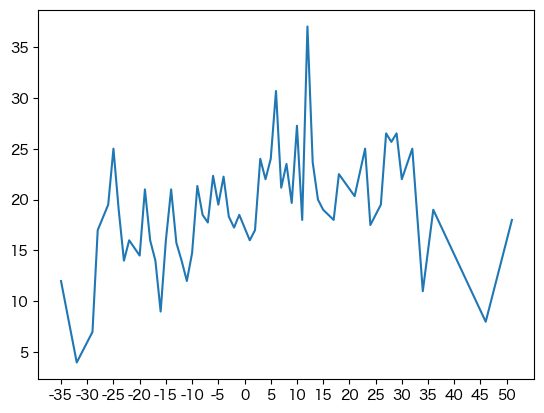

In [10]:
x = df_box_gameid_sum_alphas_scores['得点差']
y = df_box_gameid_sum_alphas_scores['フリースロー試投']
plt.plot(x, y)
plt.xticks(np.arange(x.min(), x.max(), 5))
plt.show()